In [ ]:
import pandas as pd

# Load the merged data
df = pd.read_excel("../data/interim/merged_panel_project.xlsx")

# Encode project_type manually
df["type_encoded"] = df["project_type"].map({
    "Research Based": 1,
    "System Development": 0
})

# Encode project_area using LabelEncoder
# Project area mapping by first appearance
unique_areas = df["project_area"].drop_duplicates()
area_map = {name: idx for idx, name in enumerate(unique_areas)}
df["area_encoded"] = df["project_area"].map(area_map)

# Lecturer name mapping by first appearance, starting from 1
unique_lecturers = df["lecturer_name"].drop_duplicates()
lecturer_map = {name: idx + 1 for idx, name in enumerate(unique_lecturers)}
df["lecturer_encoded"] = df["lecturer_name"].map(lecturer_map)

df[["area_encoded", "type_encoded", "lecturer_encoded"]].head(10)

,area_encoded,type_encoded,lecturer_encoded
0,0,1,1
1,0,1,2
2,1,0,3
3,1,0,4
4,1,0,5
5,1,0,6
6,2,0,7
7,2,0,8
8,3,1,9
9,3,1,10


In [2]:
df["lecturer_encoded"].value_counts()

lecturer_encoded
39     90
34     65
36     64
35     64
62     63
       ..
104     2
105     2
107     2
106     1
108     1
Name: count, Length: 108, dtype: int64

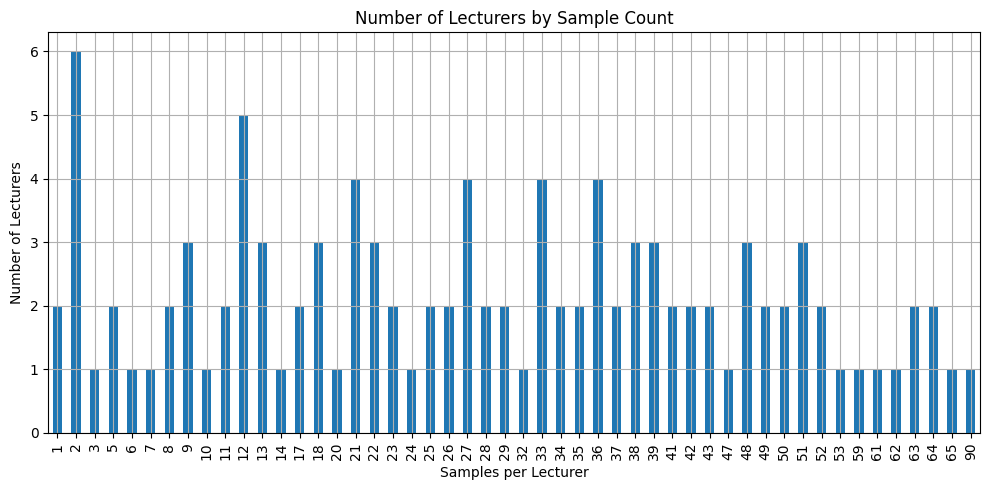

In [3]:
import matplotlib.pyplot as plt

df["lecturer_encoded"].value_counts().value_counts().sort_index().plot(kind="bar", figsize=(10,5))
plt.title("Number of Lecturers by Sample Count")
plt.xlabel("Samples per Lecturer")
plt.ylabel("Number of Lecturers")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
lecturer_counts = df["lecturer_encoded"].value_counts()
lecturers_with_one_sample = lecturer_counts[lecturer_counts == 1].index
rare_rows_df = df[df["lecturer_encoded"].isin(lecturers_with_one_sample)]

print("Lecturers with only one sample:",  rare_rows_df)

Lecturers with only one sample:            project_area    project_type        lecturer_name  type_encoded  \
2522  Augmented Reality  Research Based     ARYATI BT. BAKRI             1   
2888   Machine Learning  Research Based  ROLIANA BT. IBRAHIM             1   

      area_encoded  lecturer_encoded  
2522             3               106  
2888             0               108  


In [5]:
print(df.tail(2))

     project_area    project_type             lecturer_name  type_encoded  \
3171     Security  Research Based  BANDER ALI SALEH AL-RIMY             1   
3172     Security  Research Based      SHUKOR BIN ABD RAZAK             1   

      area_encoded  lecturer_encoded  
3171             4                12  
3172             4                71  


In [6]:
print(df.shape)

(3173, 6)


In [7]:
#duplicate panel with only one sample

df_augmented = pd.concat([df, rare_rows_df], ignore_index=True)

print(df_augmented.tail(2))

           project_area    project_type        lecturer_name  type_encoded  \
3173  Augmented Reality  Research Based     ARYATI BT. BAKRI             1   
3174   Machine Learning  Research Based  ROLIANA BT. IBRAHIM             1   

      area_encoded  lecturer_encoded  
3173             3               106  
3174             0               108  


In [8]:
print(df_augmented.shape)

(3175, 6)


In [9]:
df_augmented["lecturer_encoded"].value_counts()

lecturer_encoded
39     90
34     65
36     64
35     64
62     63
       ..
104     2
105     2
106     2
107     2
108     2
Name: count, Length: 108, dtype: int64

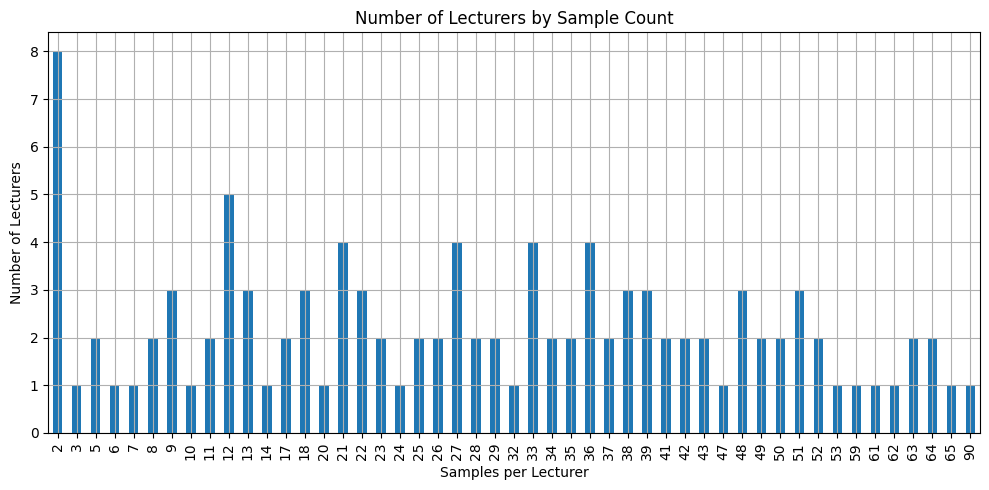

In [10]:
df_augmented["lecturer_encoded"].value_counts().value_counts().sort_index().plot(kind="bar", figsize=(10,5))
plt.title("Number of Lecturers by Sample Count")
plt.xlabel("Samples per Lecturer")
plt.ylabel("Number of Lecturers")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = df_augmented[["type_encoded", "area_encoded"]]
y = df_augmented["lecturer_encoded"]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [12]:
import graphviz
import re
from sklearn.tree import export_graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

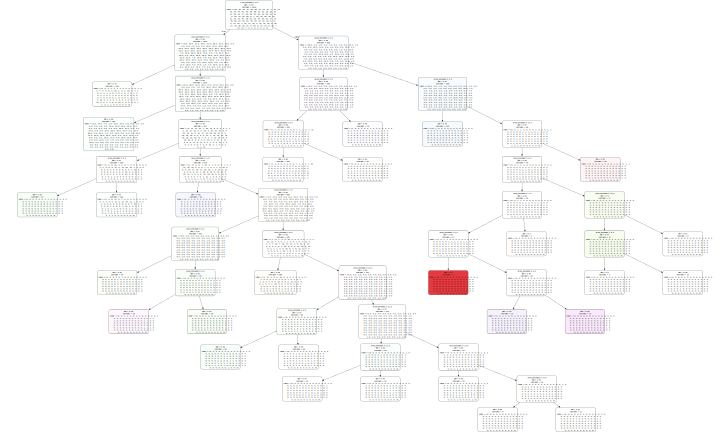

In [13]:
draw_tree(model, X_train, size=10)

In [14]:
#custom evaluation metric

from collections import defaultdict

# Create mapping: lecturer_encoded → set of (area_encoded, type_encoded)
lecturer_history = defaultdict(set)

# Loop through the entire dataset (X and y)
for i in range(len(X)):
    area_type = (X.iloc[i]["area_encoded"], X.iloc[i]["type_encoded"])
    lecturer = y.iloc[i]
    lecturer_history[lecturer].add(area_type)

valid_matches = 0
total = len(y_pred)

for i in range(total):
    area_type = (X_test.iloc[i]["area_encoded"], X_test.iloc[i]["type_encoded"])
    predicted_lecturer = y_pred[i]

    if area_type in lecturer_history[predicted_lecturer]:
        valid_matches += 1


In [15]:
custom_accuracy = valid_matches / total
print(f"✅ Custom historical validation accuracy: {custom_accuracy:.2%}")

✅ Custom historical validation accuracy: 100.00%


In [16]:
panel_list = df_augmented[["lecturer_encoded", "lecturer_name"]].drop_duplicates().sort_values("lecturer_encoded")
print(panel_list)

      lecturer_encoded                 lecturer_name
0                    1   NURFAZRINA BINTI MOHD ZAMRY
1                    2          YUSLIZA BINTI YUSOFF
2                    3                AIDA BINTI ALI
3                    4         CIK SUHAIMI BIN YUSOF
4                    5        FARKHANA BINTI MUCHTAR
...                ...                           ...
2176               104   NUR EILIYAH @ WONG YEE LENG
2366               105  SYED OTHMAWI BIN ABD. RAHMAN
2522               106              ARYATI BT. BAKRI
2716               107   NOR ERNE NAZIRA BINTI BAZIN
2888               108           ROLIANA BT. IBRAHIM

[108 rows x 2 columns]


In [17]:
panel_list.to_excel("../data/processed/panel-list-ml.xlsx", index=False)

In [18]:
area_encoded_list = df_augmented[["area_encoded", "project_area"]].drop_duplicates().sort_values("area_encoded")
print(area_encoded_list)

     area_encoded                      project_area
0               0                  Machine Learning
2               1                   Web Development
6               2                  Game Development
8               3                 Augmented Reality
10              4                          Security
20              5              Financial & Business
28              6                   Computer Vision
32              7  Human-Computer Interaction (HCI)
38              8                Mobile Application
42              9                        Management
86             10                        Networking
96             11                            Others
169            12                         Education
523            13                  Health & Medical
876            14                               UTM
929            15                  Social & Tourism


In [19]:
area_encoded_list.to_excel("../data/processed/project-area-list-ml.xlsx", index=False)

In [20]:
updated_panel_project= df_augmented[["area_encoded", "type_encoded","lecturer_encoded"]]
print(updated_panel_project)

      area_encoded  type_encoded  lecturer_encoded
0                0             1                 1
1                0             1                 2
2                1             0                 3
3                1             0                 4
4                1             0                 5
...            ...           ...               ...
3170             6             0                81
3171             4             1                12
3172             4             1                71
3173             3             1               106
3174             0             1               108

[3175 rows x 3 columns]


In [21]:
updated_panel_project.to_excel("../data/processed/updated-panel-project.xlsx", index=False)